# Aerospike Connect for Spark - SparkML Prediction Model Tutorial
## Tested with Java 8, Spark 3.0.0, Python 3.7, and Aerospike Spark Connector 3.0.0

## Summary
Build a linear regression model to predict birth weight using Aerospike Database and Spark.
Here are the features used:
- gestation weeks
- mother’s age
- father’s age
- mother’s weight gain during pregnancy
- [Apgar score](https://en.wikipedia.org/wiki/Apgar_score)

Aerospike is used to store the Natality dataset that is published by CDC. The table is accessed in Apache Spark using the Aerospike Spark Connector, and Spark ML is used to build and evaluate the model. The model can later be coverted to PMML and deployed on your inference server for predictions.

### Prerequisites

1. Load Aerospike server if not alrady available - docker run -d --name aerospike -p 3000:3000 -p 3001:3001 -p 3002:3002 -p 3003:3003 aerospike
2. Feature key needs to be located in AS_FEATURE_KEY_PATH
3. [Download the connector](https://www.aerospike.com/enterprise/download/connectors/aerospike-spark/3.0.0/)

In [1]:
#IP Address or DNS name for one host in your Aerospike cluster. 
#A seed address for the Aerospike database cluster is required
AS_HOST ="127.0.0.1"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "test" 
AS_FEATURE_KEY_PATH = "/etc/aerospike/features.conf"
AEROSPIKE_SPARK_JAR_VERSION="3.0.0"

AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

In [18]:
#Locate the Spark installation - this'll use the SPARK_HOME environment variable

import findspark
findspark.init()

In [16]:
# Below will help you dowload the Spark Connector Jar if you haven't done so already.
import urllib
import os

def aerospike_spark_jar_download_url(version=AEROSPIKE_SPARK_JAR_VERSION):
    DOWNLOAD_PREFIX="https://www.aerospike.com/enterprise/download/connectors/aerospike-spark/"
    DOWNLOAD_SUFFIX="/artifact/jar"
    AEROSPIKE_SPARK_JAR_DOWNLOAD_URL = DOWNLOAD_PREFIX+AEROSPIKE_SPARK_JAR_VERSION+DOWNLOAD_SUFFIX
    return AEROSPIKE_SPARK_JAR_DOWNLOAD_URL

def download_aerospike_spark_jar(version=AEROSPIKE_SPARK_JAR_VERSION):
    JAR_NAME="aerospike-spark-assembly-"+AEROSPIKE_SPARK_JAR_VERSION+".jar"
    if(not(os.path.exists(JAR_NAME))) :
        urllib.request.urlretrieve(aerospike_spark_jar_download_url(),JAR_NAME)
    else :
        print(JAR_NAME+" already downloaded")
    return os.path.join(os.getcwd(),JAR_NAME)

AEROSPIKE_JAR_PATH=download_aerospike_spark_jar()
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + AEROSPIKE_JAR_PATH + ' pyspark-shell'

aerospike-spark-assembly-3.0.0.jar already downloaded


In [4]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, IntegerType, MapType, LongType, DoubleType

In [5]:
#Get a spark session object and set required Aerospike configuration properties
sc = SparkContext.getOrCreate()
print("Spark Verison:", sc.version)

spark = SparkSession(sc)
sqlContext = SQLContext(sc)

spark.conf.set("aerospike.namespace",AS_NAMESPACE)
spark.conf.set("aerospike.seedhost",AS_CONNECTION_STRING)
spark.conf.set("aerospike.keyPath",AS_FEATURE_KEY_PATH )

Spark Verison: 3.0.0


## Step 1: Load Data into a DataFrame

In [6]:
as_data=spark \
.read \
.format("aerospike") \
.option("aerospike.set", "natality").load()

as_data.show(5)

print("Inferred Schema along with Metadata.")
as_data.printSchema()

+-----+--------------------+---------+------------+-------+-------------+---------------+-------------+----------+----------+----------+
|__key|            __digest| __expiry|__generation|  __ttl|   weight_pnd|weight_gain_pnd|gstation_week|apgar_5min|mother_age|father_age|
+-----+--------------------+---------+------------+-------+-------------+---------------+-------------+----------+----------+----------+
| null|[00 E0 68 A0 09 5...|354071840|           1|2367835| 6.9996768185|             99|           36|        99|        13|        15|
| null|[01 B0 1F 4D D6 9...|354071839|           1|2367834|  5.291094288|             18|           40|         9|        14|        99|
| null|[02 C0 93 23 F1 1...|354071837|           1|2367832| 6.8122838958|             24|           39|         9|        42|        36|
| null|[02 B0 C4 C7 3B F...|354071838|           1|2367833|7.67649596284|             99|           39|        99|        14|        99|
| null|[02 70 2A 45 E4 2...|354071843|   

### To speed up the load process at scale, use the [knobs](https://www.aerospike.com/docs/connect/processing/spark/performance.html) available in the Aerospike Spark Connector. 
For example, **spark.conf.set("aerospike.partition.factor", 15 )** will map 4096 Aerospike partitions to 32K Spark partitions. <font color=red> (Note: Please configure this carefully based on the available resources (CPU threads) in your system.)</font>

## Step 2 - Prep data

In [7]:
# This Spark3.0 setting, if true, will turn on Adaptive Query Execution (AQE), which will make use of the 
# runtime statistics to choose the most efficient query execution plan. It will speed up any joins that you
# plan to use for data prep step.
spark.conf.set("spark.sql.adaptive.enabled", 'true')

# Run a query in Spark SQL to ensure no NULL values exist.
as_data.createOrReplaceTempView("natality")

sql_query = """
SELECT *
from natality
where weight_pnd is not null
and mother_age is not null
and father_age is not null
and father_age < 80
and gstation_week is not null
and weight_gain_pnd < 90
and apgar_5min != "99"
and apgar_5min != "88"
"""
clean_data = spark.sql(sql_query)

#Drop the Aerospike metadata from the dataset because its not required. 
#The metadata is added because we are inferring the schema as opposed to providing a strict schema
columns_to_drop = ['__key','__digest','__expiry','__generation','__ttl' ]
clean_data = clean_data.drop(*columns_to_drop)

# dropping null values
clean_data = clean_data.dropna()


clean_data.cache()
clean_data.show(5)

#Descriptive Analysis of the data
clean_data.describe().toPandas().transpose()

+------------------+---------------+-------------+----------+----------+----------+
|        weight_pnd|weight_gain_pnd|gstation_week|apgar_5min|mother_age|father_age|
+------------------+---------------+-------------+----------+----------+----------+
|      7.5398093604|             38|           39|         9|        42|        41|
|      7.3634395508|             25|           37|         9|        14|        18|
|     7.06361087448|             26|           39|         9|        42|        28|
|6.1244416383599996|             20|           37|         9|        44|        41|
|     7.06361087448|             49|           38|         9|        14|        18|
+------------------+---------------+-------------+----------+----------+----------+
only showing top 5 rows



,0,1,2,3,4
summary,count,mean,stddev,min,max
weight_pnd,7897,7.107382278885445,1.4971156613504653,0.5291094288,12.62587374474
weight_gain_pnd,7897,29.840952260352033,12.356615508036581,1,89
gstation_week,7897,38.20881347347094,2.7768826637158064,18,47
apgar_5min,7897,8.866278333544384,0.7499400449037321,0,10
mother_age,7897,39.85716094719514,9.289970716881799,11,54
father_age,7897,39.920222869444096,9.791763879366636,11,78


## Step 3 Visualize Data

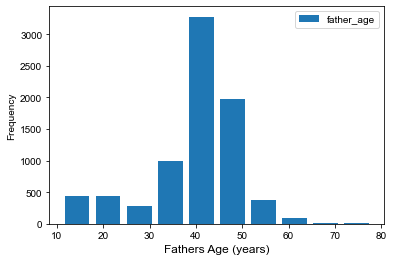

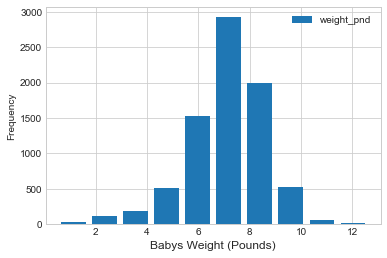

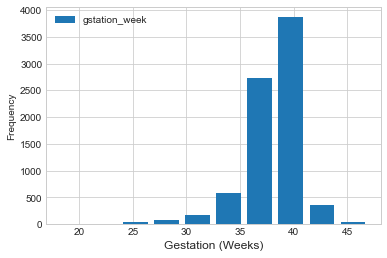

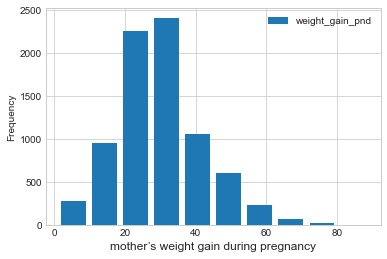

Apgar Score: Scores of 7 and above are generally normal; 4 to 6, fairly low; and 3 and below are generally regarded as critically low and cause for immediate resuscitative efforts.


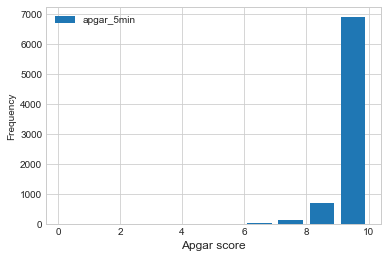

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math


pdf = clean_data.toPandas()

#Histogram - Father Age
pdf[['father_age']].plot(kind='hist',bins=10,rwidth=0.8)
plt.xlabel('Fathers Age (years)',fontsize=12)
plt.legend(loc=None)
plt.style.use('seaborn-whitegrid')
plt.show()

'''
pdf[['mother_age']].plot(kind='hist',bins=10,rwidth=0.8)
plt.xlabel('Mothers Age (years)',fontsize=12)
plt.legend(loc=None)
plt.style.use('seaborn-whitegrid')
plt.show()
'''

pdf[['weight_pnd']].plot(kind='hist',bins=10,rwidth=0.8)
plt.xlabel('Babys Weight (Pounds)',fontsize=12)
plt.legend(loc=None)
plt.style.use('seaborn-whitegrid')
plt.show()

pdf[['gstation_week']].plot(kind='hist',bins=10,rwidth=0.8)
plt.xlabel('Gestation (Weeks)',fontsize=12)
plt.legend(loc=None)
plt.style.use('seaborn-whitegrid')
plt.show()

pdf[['weight_gain_pnd']].plot(kind='hist',bins=10,rwidth=0.8)
plt.xlabel('mother’s weight gain during pregnancy',fontsize=12)
plt.legend(loc=None)
plt.style.use('seaborn-whitegrid')
plt.show()

#Histogram - Apgar Score
print("Apgar Score: Scores of 7 and above are generally normal; 4 to 6, fairly low; and 3 and below are generally \
regarded as critically low and cause for immediate resuscitative efforts.")
pdf[['apgar_5min']].plot(kind='hist',bins=10,rwidth=0.8)
plt.xlabel('Apgar score',fontsize=12)
plt.legend(loc=None)
plt.style.use('seaborn-whitegrid')
plt.show()

## Step 4 - Create Model

**Steps used for model creation:**
1. Split cleaned data into Training and Test sets
2. Vectorize features on which the model will be trained
3. Create a linear regression model (Choose any ML algorithm that provides the best fit for the given dataset)
4. Train model (Although not shown here, you could use K-fold cross-validation and Grid Search to choose the best hyper-parameters for the model)
5. Evaluate model

In [9]:
# Define a function that collects the features of interest
# (mother_age, father_age, and gestation_weeks) into a vector.
# Package the vector in a tuple containing the label (`weight_pounds`) for that
# row.## 

def vector_from_inputs(r):
  return (r["weight_pnd"], Vectors.dense(float(r["mother_age"]),
                                            float(r["father_age"]),
                                            float(r["gstation_week"]),
                                            float(r["weight_gain_pnd"]),
                                            float(r["apgar_5min"])))




In [10]:
#Split that data 70% training and 30% Evaluation data
train, test = clean_data.randomSplit([0.7, 0.3])

#Check the shape of the data
train.show()
print((train.count(), len(train.columns)))
test.show()
print((test.count(), len(test.columns)))

+------------------+---------------+-------------+----------+----------+----------+
|        weight_pnd|weight_gain_pnd|gstation_week|apgar_5min|mother_age|father_age|
+------------------+---------------+-------------+----------+----------+----------+
|      4.0565056208|             50|           33|         9|        44|        41|
|     4.68702769012|             70|           36|         9|        44|        40|
|     4.87442061282|             23|           33|         9|        43|        46|
|6.1244416383599996|             20|           37|         9|        44|        41|
|6.2501051276999995|             12|           38|         9|        44|        45|
|     6.56316153974|             40|           38|         9|        47|        45|
|      6.7681914434|             33|           39|        10|        47|        45|
|     6.87621795178|             19|           38|         9|        44|        46|
|     7.06361087448|             26|           39|         9|        42|    

In [11]:
# Create an input DataFrame for Spark ML using the above function.
training_data = train.rdd.map(vector_from_inputs).toDF(["label",
                                                        "features"])
    
# Construct a new LinearRegression object and fit the training data.
lr = LinearRegression(maxIter=5, regParam=0.2, solver="normal")

#Voila! your first model using Spark ML is trained
model = lr.fit(training_data)

# Print the model summary.
print("Coefficients:" + str(model.coefficients))
print("Intercept:" + str(model.intercept))
print("R^2:" + str(model.summary.r2))
model.summary.residuals.show()

Coefficients:[0.00858931617782676,0.0008477851947958541,0.27948866120791893,0.009329081045860402,0.18817058385589935]
Intercept:-5.893364345930709
R^2:0.3970187134779115
+--------------------+
|           residuals|
+--------------------+
|  -1.845934264937739|
| -2.2396120149639067|
| -0.7717836944756593|
| -0.6160804608336026|
| -0.6986641251138215|
|  -0.672589930891391|
| -0.8699157049741881|
|-0.13870265354963962|
|-0.26366319351660383|
| -0.5260646593713352|
|  0.3191520988648042|
| 0.08956511232072462|
| 0.28423773834709554|
|  0.5367216316177004|
|-0.34304851596998454|
|   0.613435294490146|
|  1.3680838827256254|
|  -1.887922569557201|
| -1.4788456210255978|
| -1.5035698497034602|
+--------------------+
only showing top 20 rows



### Evaluate Model

In [12]:
eval_data = test.rdd.map(vector_from_inputs).toDF(["label",
                                                    "features"])

eval_data.show()

evaluation_summary = model.evaluate(eval_data)


print("MAE:", evaluation_summary.meanAbsoluteError)
print("RMSE:", evaluation_summary.rootMeanSquaredError)
print("R-squared value:", evaluation_summary.r2)

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
|     3.62439958728|[42.0,37.0,35.0,5...|
|      5.3351867404|[43.0,48.0,38.0,6...|
|      6.8122838958|[42.0,36.0,39.0,2...|
|      6.9776305923|[46.0,42.0,39.0,2...|
|     7.06361087448|[14.0,18.0,38.0,4...|
|      7.3634395508|[14.0,18.0,37.0,2...|
|      7.4075320032|[45.0,45.0,38.0,1...|
|     7.68751907594|[42.0,49.0,38.0,2...|
|     3.09088091324|[43.0,46.0,32.0,4...|
|     5.62619692624|[44.0,50.0,39.0,2...|
|6.4992274837599995|[42.0,47.0,39.0,2...|
|6.5918216337999995|[42.0,38.0,35.0,6...|
| 6.686620406459999|[14.0,17.0,38.0,3...|
|      6.6910296517|[42.0,42.0,40.0,3...|
|      6.8122838958|[14.0,15.0,35.0,1...|
|      7.1870697412|[14.0,15.0,36.0,4...|
|      7.4075320032|[43.0,45.0,40.0,1...|
|      7.4736706818|[43.0,53.0,37.0,4...|
|     7.62578964258|[43.0,46.0,38.0,3...|
|     7.62578964258|[42.0,37.0,39.0,3...|
+------------------+--------------

## Step 5 - Batch Prediction

In [13]:
#eval_data contains the records (ideally production) that you'd like to use for the prediction

predictions = model.transform(eval_data)
predictions.show()

+------------------+--------------------+-----------------+
|             label|            features|       prediction|
+------------------+--------------------+-----------------+
|     3.62439958728|[42.0,37.0,35.0,5...|6.440847435018738|
|      5.3351867404|[43.0,48.0,38.0,6...| 6.88674880594522|
|      6.8122838958|[42.0,36.0,39.0,2...|7.315398187463249|
|      6.9776305923|[46.0,42.0,39.0,2...|7.382829406480911|
|     7.06361087448|[14.0,18.0,38.0,4...|7.013375565916365|
|      7.3634395508|[14.0,18.0,37.0,2...|6.509988959607797|
|      7.4075320032|[45.0,45.0,38.0,1...|7.013333055266812|
|     7.68751907594|[42.0,49.0,38.0,2...|7.244430398689434|
|     3.09088091324|[43.0,46.0,32.0,4...|5.543968185959089|
|     5.62619692624|[44.0,50.0,39.0,2...|7.344445812546044|
|6.4992274837599995|[42.0,47.0,39.0,2...|7.287407500422561|
|6.5918216337999995|[42.0,38.0,35.0,6...| 6.56297327380972|
| 6.686620406459999|[14.0,17.0,38.0,3...|7.079420310981281|
|      6.6910296517|[42.0,42.0,40.0,3...

#### Compare the labels and the predictions, they should ideally match up for an accurate model. Label is the actual weight of the baby and prediction is the predicated weight

### Saving the Predictions to Aerospike for ML Application's consumption

In [14]:
# Aerospike is a key/value database, hence a key is needed to store the predictions into the database. Hence we need 
# to add the _id column to the predictions using SparkSQL

predictions.createOrReplaceTempView("predict_view")
                       
sql_query = """
SELECT *, monotonically_increasing_id() as _id
from predict_view
"""
predict_df = spark.sql(sql_query)
predict_df.show()
print("#records:", predict_df.count())

+------------------+--------------------+-----------------+----------+
|             label|            features|       prediction|       _id|
+------------------+--------------------+-----------------+----------+
|     3.62439958728|[42.0,37.0,35.0,5...|6.440847435018738|         0|
|      5.3351867404|[43.0,48.0,38.0,6...| 6.88674880594522|         1|
|      6.8122838958|[42.0,36.0,39.0,2...|7.315398187463249|         2|
|      6.9776305923|[46.0,42.0,39.0,2...|7.382829406480911|         3|
|     7.06361087448|[14.0,18.0,38.0,4...|7.013375565916365|         4|
|      7.3634395508|[14.0,18.0,37.0,2...|6.509988959607797|         5|
|      7.4075320032|[45.0,45.0,38.0,1...|7.013333055266812|         6|
|     7.68751907594|[42.0,49.0,38.0,2...|7.244430398689434|         7|
|     3.09088091324|[43.0,46.0,32.0,4...|5.543968185959089|8589934592|
|     5.62619692624|[44.0,50.0,39.0,2...|7.344445812546044|8589934593|
|6.4992274837599995|[42.0,47.0,39.0,2...|7.287407500422561|8589934594|
|6.591

In [15]:
# Now we are good to write the Predictions to Aerospike
predict_df \
.write \
.mode('overwrite') \
.format("aerospike")  \
.option("aerospike.writeset", "predictions")\
.option("aerospike.updateByKey", "_id") \
.save()

#### You can verify that data is written to Aerospike by using either [AQL](https://www.aerospike.com/docs/tools/aql/data_management.html) or the [Aerospike Data Browser](https://github.com/aerospike/aerospike-data-browser)

## Step 6 - Deploy
### Here are a few options:
1. Save the model to a PMML file by converting it using Jpmml/[pyspark2pmml](https://github.com/jpmml/pyspark2pmml) and load it into your production enviornment for inference.
2. Use Aerospike as an [edge database for high velocity ingestion](https://medium.com/aerospike-developer-blog/add-horsepower-to-ai-ml-pipeline-15ca42a10982) for your inference pipline.